In [4]:
%matplotlib inline
print ('Loading LSOA polygons ...')

import geopandas as gpd

#using geopandas to load LSOA polygon file in London
filepath="LondonLSOA.geojson" 
lsoa_polygon_data = gpd.read_file(filepath)
lsoa_polygon_data = lsoa_polygon_data.rename(columns={'LSOA11CD': 'lsoa11'})



Loading LSOA polygons ...


In [5]:
import pandas as pd
sales_data_frame = pd.read_csv('london_sales_2013_2014.csv')#, delimiter=',')

# print (sales_data_frame[['transaction_id', 'price', 'lsoa11']])
lsoa_mean_prices = (sales_data_frame.groupby('lsoa11').mean())[['price']]
lsoa_mean_prices.reset_index(level=0, inplace=True)

lsoa_polygon_prices = pd.merge(lsoa_polygon_data[['lsoa11','geometry', 'LSOA11NM']], lsoa_mean_prices, on='lsoa11')


In [7]:
from bokeh.io import show
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LogColorMapper,
    ColorBar,
    LogTicker
)
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure
from bokeh.models.glyphs import Patches
from bokeh.io import output_notebook

from shapely.geometry import Polygon, mapping
from shapely.geometry import Point

palette.reverse()
color_mapper = LogColorMapper(palette=palette)

lsoa_xs = []
lsoa_ys = []
lsoa_names = []
lsoa_prices = []
for index, row in lsoa_polygon_prices.iterrows():
    
    #extracting coordinates from polygons 
    mapped_polygon = (mapping(row['geometry']))
    coordinates = (mapped_polygon['coordinates'][0][0])
    xs = [i[0] for i in coordinates]
    ys = [i[1] for i in coordinates]

    lsoa_xs.append(xs)
    lsoa_ys.append(ys)

    lsoa_names.append(row['LSOA11NM'])
    lsoa_prices.append(row['price'])


source = ColumnDataSource(data=dict(
    x=lsoa_xs,
    y=lsoa_ys,
    name=lsoa_names,
    price=lsoa_prices,
))


output_notebook()
TOOLS = "pan,wheel_zoom,reset,hover,save"
p = figure(title="London Mean House Prices, 2013-2014", tools=TOOLS, plot_width=800)

#generate polygon patches and colour them according to mean house price
p.patches('x', 'y', source=source,
          fill_color={'field': 'price', 'transform': color_mapper},
          fill_alpha=0.7, line_color="black", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))


#configure hover tool
hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name"),
    ("Mean price)", "@price"),
    ("(Long, Lat)", "($x, $y)"),
]
p.add_layout(color_bar, 'left')

show(p)



Loading BokehJS ...

             y_col     x_col  year
2335906  51.356539 -0.150428  2012
2335907  51.356539 -0.150428  2012
2335908  51.501555 -0.385509  2012
2335909  51.501555 -0.385509  2012
2335910  51.563883 -0.462092  2012


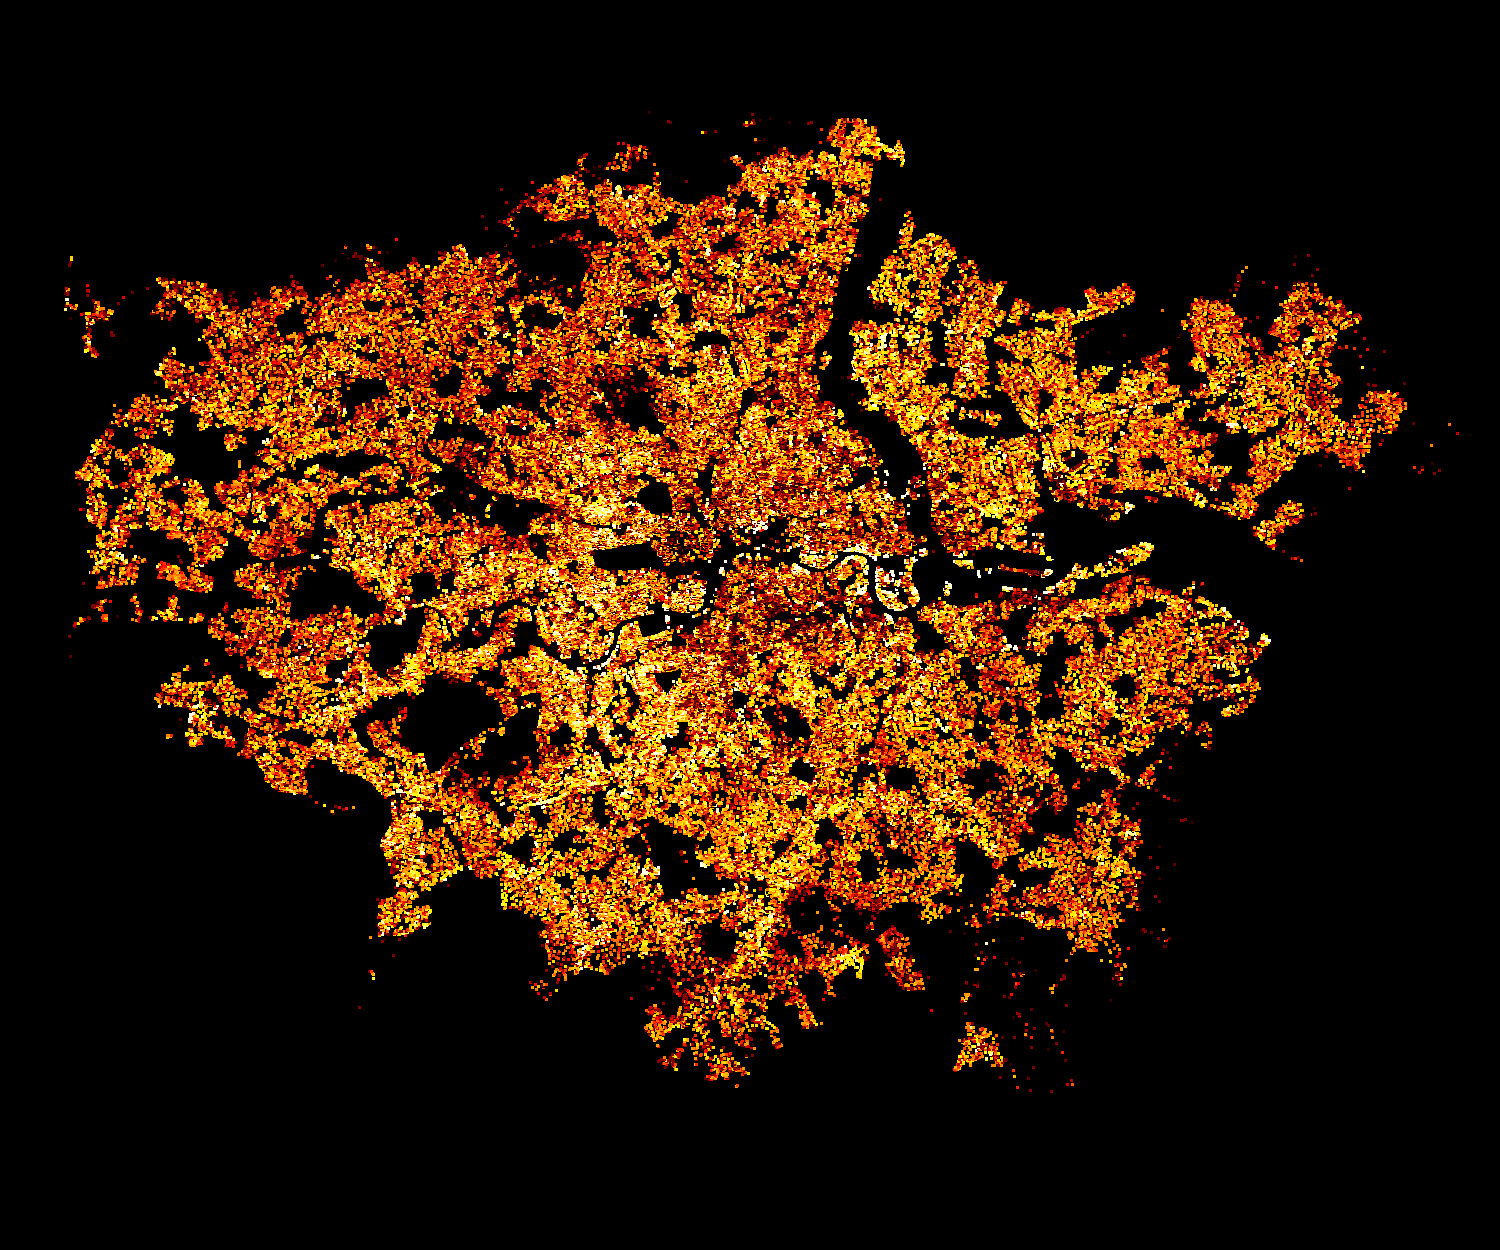

In [8]:
import datashader as ds
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display
import pandas as pd
from datashader import transfer_functions as tf

year = None

#define a bounding box around London
london = [-0.535583, 51.73, 0.334, 51.23 , 'london']

#read postcode frequency data: y_col,x_col,year: 51.464568,0.161226,1995
df = pd.read_csv('postcode_freq_data.csv')

city = london 
maxLong = city[2]
minLong = city[0]
maxLat = city[1]
minLat = city[3]

#filter out "noisy" data
if year == None:
    df = df.loc[(df['x_col'] < maxLong) & (df['x_col'] > minLong) & (df['y_col'] > minLat) & (df['y_col'] < maxLat)] 
else:
    #consider annual filtering
    df = df.loc[(df['x_col'] < maxLong) & (df['x_col'] > minLong) & (df['y_col'] > minLat) & (df['y_col'] < maxLat) & (df['year'] == year)] 

print (df.tail())

LDN = x_range, y_range = ((minLong,maxLong), (minLat, maxLat))

#define resolution of image: may need to change for varying data volumes
plot_width  = int(1500)
plot_height = int(plot_width//1.2)
background = "black"
export = partial(export_image, export_path="export", background=background)

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    #set up canvas and populate with datapoints
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x_col', 'y_col')
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

export(create_image(*LDN), city[4] + '_' +  str(year) + '_hot')

In [9]:
lsoa_socioeconomic = pd.read_csv('lsoa_imd_london.csv')
# print (lsoa_socioeconomic[['Local Authority District code (2013)','IMD Score']])
lsoa_to_imd = dict(zip(lsoa_socioeconomic['LSOA code (2011)'], lsoa_socioeconomic['IMD Score']))

lsoa_polygon_prices['IMD Score'] =  lsoa_polygon_prices['lsoa11'].map(lsoa_to_imd)

corr = lsoa_polygon_prices['IMD Score'].corr(lsoa_polygon_prices['price'])

import pylab as plt
plt.loglog(lsoa_polygon_prices['IMD Score'], lsoa_polygon_prices['price'], 'b.')
plt.xlabel('IMD Score')
plt.ylabel('Mean Price')
plt.title('Pearson's r: ' + (str(corr)[0:5]) )
# lsoa_polygon_prices.plot(kind='scatter', x='IMD Score', y='price');

SyntaxError: invalid syntax (<ipython-input-9-14bd69ee8b0c>, line 13)

In [149]:
from geopandas import GeoDataFrame

# shape = shapely.geometry.asShape(polygon)
# print(shape.bounds)

london_places = pd.read_csv('london_locations.csv')
london_places['geometry'] =  list(zip(london_places.latitude, london_places.longitude))
# print(london_places)
london_places = GeoDataFrame(london_places)
lsoa_mean_prices = GeoDataFrame(lsoa_polygon_prices)
print (lsoa_mean_prices.columns)
print (london_places.columns)
lsoa_place_frame = gpd.tools.sjoin(london_places, lsoa_mean_prices ,  how="left")
print(lsoa_place_frame)

Index(['lsoa11', 'geometry', 'LSOA11NM', 'price'], dtype='object')
Index(['place_id', 'latitude', 'longitude', 'category', 'checkins',
       'geometry'],
      dtype='object')


AttributeError: 'tuple' object has no attribute 'bounds'